In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
order_report = pd.read_excel('Company X - Order Report.xlsx')
pincode_zone = pd.read_excel('Company X - Pincode Zones.xlsx')
sku_master = pd.read_excel('Company X - SKU Master.xlsx')
c_invoice = pd.read_excel('Courier Company - Invoice.xlsx')
c_rates = pd.read_excel("Courier Company - Rates.xlsx")

In [3]:
order_report=pd.merge(order_report,sku_master,how='outer',on='SKU')

def adding_quantity(qty, weight):
    return weight*qty

order_report['Weight (g)'] = order_report.apply(lambda x: adding_quantity(x['Order Qty'], x['Weight (g)']),axis=1)

In [4]:
new_data = order_report.groupby('ExternOrderNo')['Weight (g)'].sum().sort_values(ascending = False)

df = pd.DataFrame(new_data)
df.reset_index(inplace=True)

df['Weight (kg)'] = df['Weight (g)']/1000

def slab_function(s):
    if (s>=0 and s<0.95):
        return 0.5
    elif (s>=0.95 and s<1.2):
        return 1
    elif (s>=1.2 and s<1.95):
        return 1.5
    elif (s>=1.95 and s<2.2):
        return 2
    elif (s>=2.2 and s<2.95):
        return 2.5
    
df["Slab"] = df["Weight (kg)"].apply(slab_function)

In [5]:
df.to_csv('Slab_data.csv')
df.head()

,ExternOrderNo,Weight (g),Weight (kg),Slab
0,2001809820,3080.0,3.080,NaN
1,2001812854,2572.0,2.572,2.5
2,2001806408,2265.0,2.265,2.5
3,2001827036,2176.0,2.176,2.0
4,2001821185,2098.0,2.098,2.0


In [6]:
xzone = pd.read_excel('Company X - Pincode Zones.xlsx')
invoice = pd.read_excel('Courier Company - Invoice.xlsx')

merge = pd.merge(xzone,invoice,how='left',on='Customer Pincode')

merge.drop('Warehouse Pincode_x',inplace=True,axis=1)
merge.drop('Zone_x',inplace=True,axis=1)
merge.drop('Charged Weight',inplace=True,axis=1)
merge.drop('Billing Amount (Rs.)',inplace=True,axis=1)

df = pd.read_excel('Courier Company - Rates.xlsx')

rates = df.to_numpy()
rate = rates[0]

d={}
for i in range(0,20):
    d[df.columns[i]] = rate[i]

In [7]:
xslab = pd.read_csv('Slab_data.csv')

In [8]:
xslab.drop('Unnamed: 0',inplace=True,axis=1)
xslab.rename(columns = {'ExternOrderNo':'Order ID'}, inplace = True)
charges=pd.merge(merge,xslab,how='left',on='Order ID')
charges.rename(columns = {'Warehouse Pincode_y':'Warehouse Pincode','Zone_y':'X Zone'}, inplace = True)

def slab_rate_cal(slab, val, additional):
    i = slab/0.5
    while i >= 2:
        val += additional
        i = i - 1
    return val

def newcolumn(shipment,zone,slab):
    if shipment == 'Forward charges':
        if zone == 'a':
            return slab_rate_cal(slab, 29.5, 23.6)
        elif zone == 'b':
            return slab_rate_cal(slab, 33.0, 28.3)
        elif zone == 'c':
            return slab_rate_cal(slab, 40.1, 38.9)
        elif zone == 'd':
            return slab_rate_cal(slab, 45.4, 44.8)
        else:
            return slab_rate_cal(slab, 56.6, 55.5)
    else:
        if zone == 'a':
            return slab_rate_cal(slab, 29.5+13.6, 23.6)
        elif zone == 'b':
            return slab_rate_cal(slab, 33.0+20.5, 28.3)
        elif zone == 'c':
            return slab_rate_cal(slab, 40.1+31.9, 38.9)
        elif zone == 'd':
            return slab_rate_cal(slab, 45.4+41.3, 44.8)
        else:
            return slab_rate_cal(slab, 56.6+50.7, 55.5)
            
charges['Expected charge by x'] = charges.apply(lambda x: newcolumn(x['Type of Shipment'], x['X Zone'],x['Slab']),axis=1)

In [9]:
charges.to_csv('Expected charge as per X')
charges.head()

,Customer Pincode,AWB Code,Order ID,Warehouse Pincode,X Zone,Type of Shipment,Weight (g),Weight (kg),Slab,Expected charge by x
0,507101,1091117222124,2001806232,121003,d,Forward charges,1302.0,1.302,1.5,135.0
1,486886,1091117222194,2001806273,121003,d,Forward charges,615.0,0.615,0.5,45.4
2,532484,1091117222931,2001806408,121003,d,Forward charges,2265.0,2.265,2.5,224.6
3,143001,1091117223244,2001806458,121003,b,Forward charges,700.0,0.700,0.5,33.0
4,515591,1091117229345,2001807012,121003,d,Forward charges,240.0,0.240,0.5,45.4


In [10]:
invoice = pd.read_excel('Courier Company - Invoice.xlsx')
xdata = pd.read_csv('Expected charge as per X')

In [11]:
xdata.drop('Unnamed: 0',inplace=True,axis=1)

final_data=pd.merge(invoice,xdata,how='right',on='Order ID')

final_data.drop('AWB Code_x',inplace=True,axis=1)
final_data.drop('Warehouse Pincode_x',inplace=True,axis=1)
final_data.drop('Customer Pincode_x',inplace=True,axis=1)
final_data.drop('Warehouse Pincode_y',inplace=True,axis=1)
final_data.drop('Customer Pincode_y',inplace=True,axis=1)
final_data.drop('Type of Shipment_x',inplace=True,axis=1)
final_data.drop('Type of Shipment_y',inplace=True,axis=1)
final_data.drop('Weight (g)',inplace=True,axis=1)

final_data['AWB Number'] = final_data['AWB Code_y']
final_data.drop('AWB Code_y',inplace=True,axis=1)
final_data['Total weight as per X'] = final_data['Weight (kg)']
final_data.drop('Weight (kg)',inplace=True,axis=1)
final_data['Weight Slab as per X'] = final_data['Slab']
final_data.drop('Slab',inplace=True,axis=1)
final_data['Total Weight as per Courier Company'] = final_data['Charged Weight']
final_data.drop('Charged Weight',inplace=True,axis=1)

def slab_function(s):
    if (s>=0 and s<0.95):
        return 0.5
    elif (s>=0.95 and s<1.2):
        return 1
    elif (s>=1.2 and s<1.95):
        return 1.5
    elif (s>=1.95 and s<2.2):
        return 2
    elif (s>=2.2 and s<2.95):
        return 2.5
    
final_data['Weight Slab Charged by Courier Company'] = final_data['Total Weight as per Courier Company'].apply(slab_function)

final_data['Delivery Zone as per X'] = final_data['X Zone']
final_data.drop('X Zone',inplace=True,axis=1)
final_data['Delivery Zone as per Courier Company'] = final_data['Zone']
final_data.drop('Zone',inplace=True,axis=1)
final_data['Expected charges as per X'] = final_data['Expected charge by x']
final_data.drop('Expected charge by x',inplace=True,axis=1)
final_data['Charges billed by Courier Company'] = final_data['Billing Amount (Rs.)']
final_data.drop('Billing Amount (Rs.)',inplace=True,axis=1)

final_data['Difference between Expected and billed charges'] = final_data['Expected charges as per X'] - final_data['Charges billed by Courier Company']

def value_correction(num):
    if num == -1.4210854715202004e-14:
        return 0.0
    else:
        num = float("%.2f" % float(num))
        return num

final_data['Difference between Expected and billed charges'] = final_data['Difference between Expected and billed charges'].apply(value_correction)

In [12]:
final_data.to_excel('FinalOutput.xlsx')
final_data.head()

,Order ID,AWB Number,Total weight as per X,Weight Slab as per X,Total Weight as per Courier Company,Weight Slab Charged by Courier Company,Delivery Zone as per X,Delivery Zone as per Courier Company,Expected charges as per X,Charges billed by Courier Company,Difference between Expected and billed charges
0,2001806232,1091117222124,1.302,1.5,1.30,1.5,d,d,135.0,135.0,0.0
1,2001806273,1091117222194,0.615,0.5,1.00,1.0,d,d,45.4,90.2,-44.8
2,2001806408,1091117222931,2.265,2.5,2.50,2.5,d,d,224.6,224.6,0.0
3,2001806458,1091117223244,0.700,0.5,1.00,1.0,b,b,33.0,61.3,-28.3
4,2001807012,1091117229345,0.240,0.5,0.15,0.5,d,d,45.4,45.4,0.0


Text(0.5, 1.0, 'Charges billed by Courier Company')

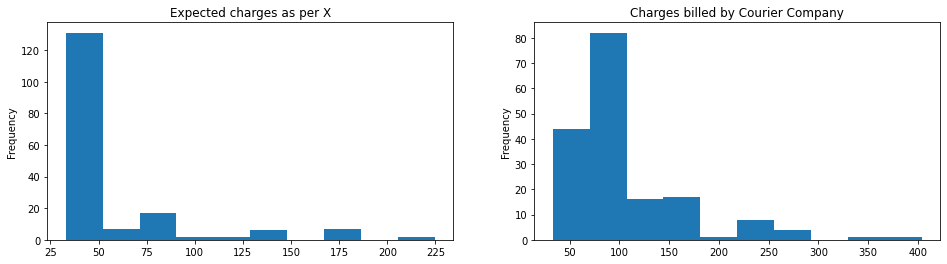

In [13]:
# sns.jointplot('Expected charges as per X','Charges billed by Courier Company',data=final_data)
fig = plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
final_data['Expected charges as per X'].plot.hist()
plt.title('Expected charges as per X')

plt.subplot(1,2,2)
final_data['Charges billed by Courier Company'].plot.hist()
plt.title('Charges billed by Courier Company')

#### Courier Company is charging more the Expected budget of Company X in most of the Deliveries

<AxesSubplot:xlabel='Expected charges as per X', ylabel='Charges billed by Courier Company'>

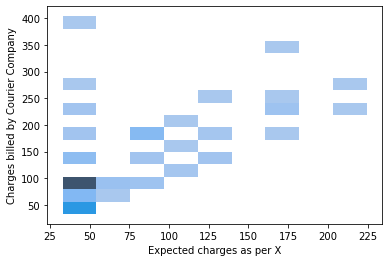

In [14]:
sns.histplot(data=final_data,x='Expected charges as per X',y='Charges billed by Courier Company')

Text(0.5, 1.0, 'Frequency of Difference between Expected and billed charges')

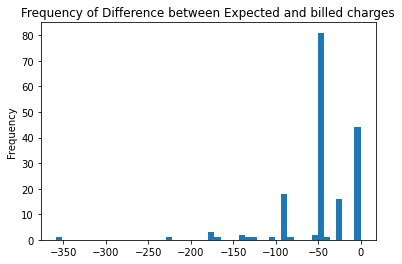

In [15]:
final_data['Difference between Expected and billed charges'].plot.hist(bins=50)
plt.title('Frequency of Difference between Expected and billed charges')

In [16]:
Xpaid = 0
for i in final_data['Expected charges as per X']:
    Xpaid += i
print('Expected Charges as per Company X :',Xpaid)

Ccharge = 0
for i in final_data['Charges billed by Courier Company']:
    Ccharge += i
print('Charges billed by Courier Company :',Ccharge)

print('Extra Charges :',Xpaid-Ccharge)

Expected Charges as per Company X : 10575.39999999997
Charges billed by Courier Company : 18432.80000000003
Extra Charges : -7857.400000000058


#### Company is having loss of 7857.41$ 

##### ==>Expected conclusion in given business problem 

In [17]:
final_data[final_data['Order ID'] == 2001806232]

,Order ID,AWB Number,Total weight as per X,Weight Slab as per X,Total Weight as per Courier Company,Weight Slab Charged by Courier Company,Delivery Zone as per X,Delivery Zone as per Courier Company,Expected charges as per X,Charges billed by Courier Company,Difference between Expected and billed charges
0,2001806232,1091117222124,1.302,1.5,1.3,1.5,d,d,135.0,135.0,0.0


In [18]:
final_data[final_data['Order ID'] == 2001806210]

,Order ID,AWB Number,Total weight as per X,Weight Slab as per X,Total Weight as per Courier Company,Weight Slab Charged by Courier Company,Delivery Zone as per X,Delivery Zone as per Courier Company,Expected charges as per X,Charges billed by Courier Company,Difference between Expected and billed charges
35,2001806210,1091117221940,0.22,0.5,2.92,2.5,b,b,33.0,174.5,-141.5
